# AWS Sagemaker: Bring Your Own Model


How to dockerize any machine learning algorithm and ship it to the cloud.

This notebook is written in conjunction with this [medium post](https://medium.com/p/92778dabb32f).

All the code we need is in the /container directory so let's change into there.

In [1]:
cd container

/home/sam/github/amazon-sagemaker-byom/container


*quick aside: If you are wondering why that bash command worked in a Python notebook it is known as an [automagic](https://jakevdp.github.io/PythonDataScienceHandbook/01.05-ipython-and-shell-commands.html) function.*

## A trained model

Let's download a trained model. This example uses [ResNet50](https://arxiv.org/abs/1512.03385) trained on ImageNet. It is one of the Keras [available models](https://keras.io/applications/#available-models).

In [2]:
!python get_model.py

Using TensorFlow backend.
2018-07-30 16:47:21.939696: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA


This downloaded *model.json* and *weights.hdf5*. These files represent the model architecture and trained weights. When you are ready you can replace them with your own trained model. Here is where they go.

In [2]:
ls model

model.json  weights.hdf5


## Build Docker image

In [4]:
# uncomment for linux installation (if required)
# !wget -qO- https://get.docker.com/ | sh

**Docker Build**

Let's name the Docker image we are about to build

**Install Docker**

To install use the Docker Toolbox for [Windows](https://docs.docker.com/toolbox/toolbox_install_windows/) or [Mac](https://docs.docker.com/toolbox/toolbox_install_mac/). If in Linux, run this command

In [73]:
name = 'test4'
tag = 'dev-1.0.0'

There are a bunch of restrictions imposed by Amazon and Docker on the name we can use. Long story short, chose a lower case alphanumeric name.

The tag has way less retrictions

Let's check the name is valid before spending the time to build an image.

In [74]:
!python name_check.py {name}

The name "test4" is valid


Assuming the name is valid, let's build the image

In [75]:
!docker build . --tag {name}:{tag}

Sending build context to Docker daemon 103.1 MB
Step 1/12 : FROM ubuntu:16.04
 ---> 7aa3602ab41e
Step 2/12 : MAINTAINER Sam Murphy <samsammurphy@gmail.com>
 ---> Using cache
 ---> 4fa72935ba65
Step 3/12 : EXPOSE 8080
 ---> Using cache
 ---> 38294f83645d
Step 4/12 : RUN apt-get -y update && apt-get install -y --no-install-recommends          wget          python          nginx          ca-certificates     && rm -rf /var/lib/apt/lists/*
 ---> Using cache
 ---> 7dfb99088673
Step 5/12 : RUN wget https://bootstrap.pypa.io/get-pip.py && python get-pip.py &&     pip install numpy==1.14.5 scipy flask gevent gunicorn Pillow &&         (cd /usr/local/lib/python2.7/dist-packages/scipy/.libs; rm *; ln ../../numpy/.libs/* .) &&         rm -rf /root/.cache
 ---> Using cache
 ---> b65b449e5339
Step 6/12 : ENV PYTHONUNBUFFERED TRUE
 ---> Using cache
 ---> 14e30ab956f1
Step 7/12 : ENV PYTHONDONTWRITEBYTECODE TRUE
 ---> Using cache
 ---> e88072e20660
Step 8/12 : ENV PATH "/opt/program:${PATH}"
 ---> Usi

## Local test

Start a local webserver with the machine learning code and endpoints all set up

In [76]:
!./run_local_server.sh {name}:{tag}

739501a7a3605d0d9c6b08741d19155007f896c16e2df656485a6ae5d38b3507


The /ping endpoint checks if the connection is up

In [78]:
!curl -X GET 'http://localhost:8080/ping'

pong

Let's take a look at one of our images.

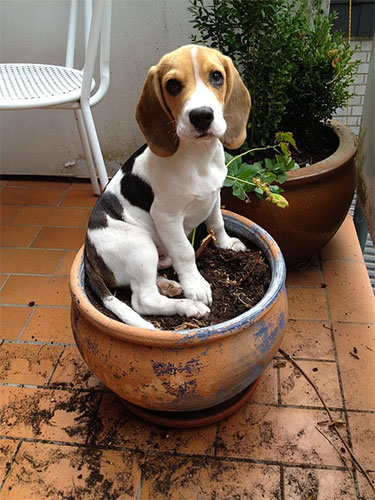

In [79]:
from IPython.display import Image
Image('../images/dog.jpg') 

and see if ResNet can determine what it is..

In [80]:
!curl -X POST -F image=@../images/dog.jpg 'http://localhost:8080/invocations'

{"predictions": [{"probability": 0.9901767373085022, "label": "beagle"}, {"probability": 0.0022487046662718058, "label": "Walker_hound"}, {"probability": 0.0011901347897946835, "label": "Brittany_spaniel"}, {"probability": 0.0011802910594269633, "label": "pot"}, {"probability": 0.0006831124192103744, "label": "Cardigan"}], "success": true}

ok, but can we can identify if something is a hotdog?

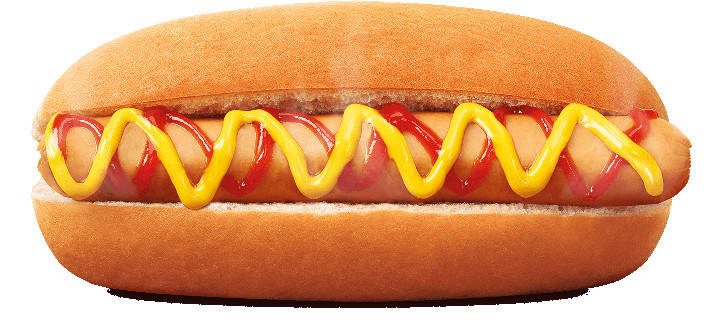

In [81]:
Image('../images/hotdog.jpg') 

In [82]:
!curl -X POST -F image=@../images/hotdog.jpg 'http://localhost:8080/invocations'

{"predictions": [{"probability": 0.9936224818229675, "label": "hotdog"}, {"probability": 0.005856595002114773, "label": "cheeseburger"}, {"probability": 0.00016705217421986163, "label": "bakery"}, {"probability": 0.00010399545863037929, "label": "tennis_ball"}, {"probability": 9.467774361837655e-05, "label": "French_loaf"}], "success": true}

Yes, it turns out we can, assuming all went well up to this point.

When you are done with local testing, kill the container running in the background.

In [83]:
!docker kill mylocalservice

mylocalservice


## Register the container

The here aim is to send a docker image to Amazon's Elastic Container Registery (ECR). It seems that Amazon are using 'image' and 'container' interchangeably. 

I am obliged to say they are not the same thing (i.e. a container is an instance of an image). 

*Aside: However, I understand why Amazon might do this. The official Docker terminology here is not ideal. Although the term 'image' has been used for a [long time](https://en.wikipedia.org/wiki/Disk_image) in computing to describe content storage, for most people the word conjures up thoughts of something like a photo, which is confusing. In my humble opinion **Docker** should haved used the term 'container' instead of image and used 'instance' instead of container.*

**Ship the image to Amazon ECR**

In [ ]:
!./send_to_Amazon.sh {name}

## Host the container

Lets define an S3 bucket and a prefix to add to the bucket contents.

*The prefix is used to organizes objects (i.e. files) inside the bucket as if they are in one or more subdirectories.*

In [ ]:
bucket = 'a-sagemaker-test'
prefix = 'sagemaker/byom'

The IAM role used for hosting the data

In [ ]:
role = 'arn:aws:iam::906157373155:role/service-role/AmazonSageMaker-ExecutionRole-20180713T155305'

The name of the container with our machine learning algorithm

In [ ]:
account=!aws sts get-caller-identity --query Account --output text
region=!aws configure get region
print(account)
print(region)

container=f'{account[0]}.dkr.ecr.{region[0]}.amazonaws.com/{name}:latest'
print(container)

The Amazon SageMaker Python client helps us communicate with Amazon. 

In [ ]:
import boto3
sm = boto3.client('sagemaker')

When we invoke client functions we get a response back from Amazon.

In [ ]:
# let's create a SageMaker model
create_model_response = sm.create_model(
    ModelName=name,
    ExecutionRoleArn=role,
    PrimaryContainer={
        'Image': container
    })

# let's check that worked
print(create_model_response['ModelArn'])

We define the compute resources that are available to an algorithm using an endpoint configuration.

In [ ]:
create_endpoint_config_response = sm.create_endpoint_config(
    EndpointConfigName='byom-endpoint-config',
    ProductionVariants=[{
        'InstanceType': 'ml.m4.xlarge',
        'InitialInstanceCount': 1,
        'ModelName': name,
        'VariantName': 'AllTraffic'}])

print(create_endpoint_config_response['EndpointConfigArn'])

We can now create the endpoint(s)

In [ ]:
endpoint_name = name+'-endpoint'

create_endpoint_response = sm.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName='byom-endpoint-config')

print(create_endpoint_response['EndpointArn'])

Let's check the status

In [ ]:
resp = sm.describe_endpoint(EndpointName=endpoint_name)
status = resp['EndpointStatus']
print("Status: " + status)

Let's keep checking automatically until it is done

In [ ]:
sm.get_waiter('endpoint_in_service').wait(EndpointName=endpoint_name)

resp = sm.describe_endpoint(EndpointName=endpoint_name)
status = resp['EndpointStatus']
print("Arn: " + resp['EndpointArn'])
print("Status: " + status)

if status != 'InService':
    raise Exception('Endpoint creation did not succeed')

**Test the endpoint**


In [ ]:
runtime = boto3.Session().client('runtime.sagemaker')

In [ ]:
with open('../images/dog.jpg', 'rb') as file:
    image_data = file.read()

In [ ]:
payload = 'bytes or seekable file-like object'

response = runtime.invoke_endpoint(EndpointName=endpoint_name,
                                   ContentType='image/jpeg',
                                   Body=image_data)

result = json.loads(response['Body'].read().decode())

print(result)

## The End

In [ ]:
sm.delete_endpoint(EndpointName=endpoint_name)